**Data Preprocessing and Correlation-Based Feature Selection (CFS) using the Bat Algorithm (BA)**

In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Path to the folder containing .parquet files
DATA_FOLDER = "/kaggle/input/cicddos2019/"

# Read all .parquet files and combine them
file_paths = glob.glob(f"{DATA_FOLDER}/*.parquet")
df_list = [pd.read_parquet(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

In [3]:
df_sampled = df.sample(frac=0.01, random_state=42)

# Save the sampled data to a CSV file
df_sampled.to_csv('end_test.csv', index=False)

print("1% sample saved as end_test.csv")

1% sample saved as end_test.csv


In [4]:
import torch
import numpy as np
from tqdm import tqdm  # optional for a clean progress bar, if needed

# =============================
# Mutual Information on GPU
# =============================
def mutual_info_gpu(X, Y, bins=10, device='cuda'):
    """
    Vectorized mutual information calculation on GPU.
    """
    # Discretize X and Y into bins
    X_bins = torch.bucketize(X, torch.linspace(torch.min(X), torch.max(X), bins + 1, device=device))
    Y_bins = torch.bucketize(Y, torch.linspace(torch.min(Y), torch.max(Y), bins + 1, device=device))

    # Create 2D indices for joint occurrences
    indices = X_bins * (bins + 1) + Y_bins

    # Flatten joint histogram using bincount (very fast on GPU)
    joint_hist_flat = torch.bincount(indices, minlength=(bins + 1) ** 2)

    # Reshape into 2D joint histogram
    joint_hist = joint_hist_flat.reshape((bins + 1, bins + 1)).float()

    # Normalize to get joint probabilities
    joint_prob = joint_hist / joint_hist.sum()

    # Marginal probabilities
    px = joint_prob.sum(dim=1, keepdim=True)
    py = joint_prob.sum(dim=0, keepdim=True)

    # Avoid division by zero
    eps = 1e-10
    ratio = joint_prob / (px @ py + eps)

    log_ratio = torch.log2(ratio + eps)
    mi = (joint_prob * log_ratio).sum()

    return mi

In [6]:
# CFS-BA GPU Main Function
def cfs_ba_gpu(X, y, num_bats=20, max_generations=50, alpha=0.9, gamma=0.9, bins=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert data to tensors
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    if isinstance(y, torch.Tensor):
        y_tensor = y.to(device)
    else:
        y_tensor = torch.tensor(y.cat.codes if hasattr(y, 'cat') else y, dtype=torch.float32, device=device)

    num_features = X_tensor.shape[1]

    # Initialize bats
    positions = torch.rand((num_bats, num_features), device=device)
    velocities = torch.zeros((num_bats, num_features), device=device)
    frequencies = torch.zeros(num_bats, device=device)
    pulse_rates = torch.ones(num_bats, device=device)
    loudness = torch.ones(num_bats, device=device)

    fitness = cfs_batch_fitness_gpu(positions, X_tensor, y_tensor, bins)
    best_index = torch.argmin(fitness)
    best_position = positions[best_index].clone()
    best_fitness = fitness[best_index].clone()

    Qmin, Qmax = 0, 2

    # Progress display in one line
    for generation in range(max_generations):
        # Update each bat
        frequencies = Qmin + (Qmax - Qmin) * torch.rand(num_bats, device=device).unsqueeze(1)

        velocities = velocities + (positions - best_position) * frequencies
        positions = positions + velocities
        positions = torch.sigmoid(positions)

        # Pulse rate condition and local search
        rand_vals = torch.rand(num_bats, device=device)
        mask = rand_vals > pulse_rates
        if mask.any():
            epsilon = torch.rand_like(positions[mask])
            positions[mask] = best_position + epsilon * torch.mean(loudness)

        # Evaluate fitness in batch
        new_fitness = cfs_batch_fitness_gpu(positions, X_tensor, y_tensor, bins)

        # Acceptance criteria
        accept_mask = (new_fitness < fitness) & (torch.rand(num_bats, device=device) < loudness)
        fitness[accept_mask] = new_fitness[accept_mask]
        loudness[accept_mask] *= alpha
        pulse_rates[accept_mask] *= (1 - torch.exp(torch.tensor(-gamma * generation, device=device)))


        # Update global best
        current_best_index = torch.argmin(fitness)
        if fitness[current_best_index] < best_fitness:
            best_fitness = fitness[current_best_index].clone()
            best_position = positions[current_best_index].clone()

        # Minimal progress output (overwrites line)
        print(f"\rGeneration {generation + 1}/{max_generations} | Best Fitness: {-best_fitness.item():.6f}", end='')

    print()  # finish the progress line

    selected_indices = (best_position > 0.5).nonzero(as_tuple=False).flatten().tolist()
    return selected_indices, -best_fitness.item()

In [5]:
# Batch Fitness Function on GPU
def cfs_batch_fitness_gpu(positions, X_tensor, y_tensor, bins=10):
    """
    Batch version of cfs_fitness_gpu.
    Each row in positions corresponds to a bat.
    """
    device = X_tensor.device
    num_bats = positions.shape[0]
    num_features = X_tensor.shape[1]

    fitness_scores = torch.zeros(num_bats, device=device)

    for idx in range(num_bats):
        pos = positions[idx]
        selected_indices = (pos > 0.5).nonzero(as_tuple=False).flatten()

        if selected_indices.numel() == 0:
            # No features selected; assign worst fitness
            fitness_scores[idx] = float('inf')
            continue

        X_selected = X_tensor[:, selected_indices]

        # Compute relevance (MI between selected features and target)
        relevance_sum = 0
        for i in range(X_selected.shape[1]):
            relevance_sum += mutual_info_gpu(X_selected[:, i], y_tensor, bins=bins, device=device)
        relevance = relevance_sum / X_selected.shape[1]

        # Compute redundancy (average MI between selected features)
        redundancy_sum = 0
        count = 0
        for i in range(X_selected.shape[1]):
            for j in range(i + 1, X_selected.shape[1]):
                redundancy_sum += mutual_info_gpu(X_selected[:, i], X_selected[:, j], bins=bins, device=device)
                count += 1
        redundancy = redundancy_sum / count if count > 0 else 0

        # CFS merit (higher is better, but BA minimizes fitness)
        merit = relevance / (torch.sqrt(torch.tensor(X_selected.shape[1], dtype=torch.float32, device=device)) + redundancy + 1e-6)

        # We minimize fitness, so use the negative of merit
        fitness_scores[idx] = -merit

    return fitness_scores


In [8]:
X = df.drop('Label', axis=1).values
y = df['Label'].astype('category')

# Convert y to numerical codes (if not already)
y_codes = y.cat.codes.values if hasattr(y, 'cat') else y

# OPTIONAL: Subsample data for speed (comment out for full data)
sample_size = 1000
sample_indices = torch.randperm(len(X))[:sample_size]
X_sampled = torch.tensor(X[sample_indices], dtype=torch.float32)
y_sampled = torch.tensor(np.array(y_codes)[sample_indices], dtype=torch.float32)

# Run CFS-BA
selected_features, best_merit = cfs_ba_gpu(X_sampled, y_sampled, num_bats=20, max_generations=50)

print(f"\nSelected feature indices (GPU): {selected_features}")
print(f"Best merit (GPU): {best_merit:.6f}")

**Model Training phase (Multi class classifier)**

In [2]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Path to the folder containing .parquet files
DATA_FOLDER = "/kaggle/input/cicddos2019/"

# Read all .parquet files and combine them
file_paths = glob.glob(f"{DATA_FOLDER}/*.parquet")
df_list = [pd.read_parquet(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

df.head(5).to_csv('first_5_rows.csv', index=False)

# Display basic info
print("Combined dataset shape:", df.shape)
print(df.head())

# Print all column names
print("Columns:", df.columns.tolist())

# Print all unique labels in the 'Label' column
print("Labels:", df['Label'].unique().tolist())


# Separate features and labels
# X = df[feature_columns].values
# y = df["Label"].values


# # Split dataset into Train (70%), Validation (15%), and Test (15%)
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Combined dataset shape: (431371, 78)
   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6            105                  2                       2   
1         6              1                  2                       0   
2         6       55295858                  8                       0   
3         6             49                  2                       0   
4         6            109                  2                       2   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                      12.0                      12.0                    6.0   
1                      12.0                       0.0                    6.0   
2                      48.0                       0.0                    6.0   
3                      12.0                       0.0                    6.0   
4                      12.0                      12.0                    6.0   

   Fwd Packet Length Min  Fwd Packet Length

In [3]:
important_features = [
    "Fwd Packets Length Total",   # 4
    "Fwd Packet Length Min",      # 7
    "Fwd Packet Length Mean",     # 8
    "Fwd Packet Length Std",      # 9
    "Bwd Packet Length Min",      # 11
    "Bwd Packet Length Mean",     # 12
    "Bwd Packet Length Std",      # 13
    "Flow Packets/s",             # 15
    "Flow IAT Std",               # 17
    "Fwd IAT Mean",               # 21
    "Fwd IAT Std",                # 22
    "Fwd IAT Max",                # 23
    "Bwd IAT Mean",               # 26
    "Bwd IAT Max",                # 28
    "Bwd IAT Min",                # 29
    "Bwd URG Flags",              # 33
    "Fwd Header Length",          # 34
    "Fwd Packets/s",              # 36
    "Bwd Packets/s",              # 37
    "Packet Length Min",          # 38
    "Packet Length Mean",         # 40
    "Packet Length Std",          # 41
    "SYN Flag Count",             # 44
    "RST Flag Count",             # 45
    "Avg Packet Size",            # 52
    "Bwd Avg Packets/Bulk",       # 59
    "Subflow Fwd Packets",        # 61
    "Init Fwd Win Bytes",         # 65
    "Active Max",                 # 71
    "Active Min",                 # 72
    "Idle Mean",                  # 73
    "Idle Min"                    # 76
]


In [4]:

# Select only important features
df_selected = df[important_features + ["Label"]]

# Normalize features
scaler = MinMaxScaler()
df_selected[important_features] = scaler.fit_transform(df_selected[important_features])

# Encode labels
label_encoder = LabelEncoder()
df_selected["Label"] = label_encoder.fit_transform(df_selected["Label"])

# Split into train, validation, and test sets
X = df_selected[important_features].values
y = df_selected["Label"].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Updated dataset shape:", X_train.shape)

<ipython-input-4-fb55e2b948ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[important_features] = scaler.fit_transform(df_selected[important_features])
<ipython-input-4-fb55e2b948ad>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["Label"] = label_encoder.fit_transform(df_selected["Label"])


Updated dataset shape: (301959, 32)


In [13]:
# Final dataset sizes
print("Data preprocessing complete!")
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Testing samples: {len(X_test)}")
print("Label encoding mapping:", dict(enumerate(label_encoder.classes_)))

Data preprocessing complete!
Training samples: 301959, Validation samples: 64706, Testing samples: 64706
Label encoding mapping: {0: 'Benign', 1: 'DrDoS_DNS', 2: 'DrDoS_LDAP', 3: 'DrDoS_MSSQL', 4: 'DrDoS_NTP', 5: 'DrDoS_NetBIOS', 6: 'DrDoS_SNMP', 7: 'DrDoS_UDP', 8: 'LDAP', 9: 'MSSQL', 10: 'NetBIOS', 11: 'Portmap', 12: 'Syn', 13: 'TFTP', 14: 'UDP', 15: 'UDP-lag', 16: 'UDPLag', 17: 'WebDDoS'}


**Multi Layer Peceptron (MLP)**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define MLP Model with Batch Normalization & ReLU
class MLP_IDS(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP_IDS, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # Logits output (No Softmax here)
        return x


In [15]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_IDS(input_dim=X_train.shape[1], num_classes=len(set(y_train))).to(device)

# Optimizer with Weight Decay
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

# Loss Function (Choose One)
criterion = nn.CrossEntropyLoss()  # Default Loss
# criterion = FocalLoss()  # Use if data is imbalanced

num_epochs = 50  # Train for 50 epochs


In [16]:
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
#         p_t = torch.exp(-ce_loss)
#         focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss

#         if self.reduction == 'mean':
#             return focal_loss.mean()
#         else:
#             return focal_loss.sum()


In [17]:
loss_values = []
accuracy_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Store loss
    loss_values.append(total_loss / len(train_loader))

    # Validation Step
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_accuracy = correct / total
    accuracy_values.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")



Epoch [1/50], Loss: 1235.8179, Validation Accuracy: 0.8359
Epoch [2/50], Loss: 519.6921, Validation Accuracy: 0.8967
Epoch [3/50], Loss: 406.6336, Validation Accuracy: 0.9043
Epoch [4/50], Loss: 359.7502, Validation Accuracy: 0.9069
Epoch [5/50], Loss: 334.8844, Validation Accuracy: 0.9099
Epoch [6/50], Loss: 319.8587, Validation Accuracy: 0.9117
Epoch [7/50], Loss: 310.2520, Validation Accuracy: 0.9125
Epoch [8/50], Loss: 303.5784, Validation Accuracy: 0.9129
Epoch [9/50], Loss: 297.3763, Validation Accuracy: 0.9139
Epoch [10/50], Loss: 292.5928, Validation Accuracy: 0.9142
Epoch [11/50], Loss: 288.0886, Validation Accuracy: 0.9152
Epoch [12/50], Loss: 285.1568, Validation Accuracy: 0.9146
Epoch [13/50], Loss: 281.2971, Validation Accuracy: 0.9151
Epoch [14/50], Loss: 279.2382, Validation Accuracy: 0.9163
Epoch [15/50], Loss: 276.3618, Validation Accuracy: 0.9167
Epoch [16/50], Loss: 274.7926, Validation Accuracy: 0.9167
Epoch [17/50], Loss: 272.5673, Validation Accuracy: 0.9168
Epoch

**Testing above model on Test Data**

 Final Test Accuracy: 0.9223
Precision (weighted): 0.9011
 Recall (weighted): 0.9223
 F1 Score (weighted): 0.9067

 Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14674
           1       0.50      0.37      0.43       550
           2       0.00      0.00      0.00       216
           3       0.00      0.00      0.00       932
           4       1.00      0.99      1.00     18206
           5       0.00      0.00      0.00        90
           6       0.36      0.86      0.51       408
           7       0.00      0.00      0.00      1563
           8       0.36      0.03      0.05       286
           9       0.48      0.94      0.64      1278
          10       0.34      0.85      0.48        97
          11       0.00      0.00      0.00       103
          12       0.98      0.94      0.96      7406
          13       1.00      0.99      1.00     14837
          14       0.58      0.96      0.72      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

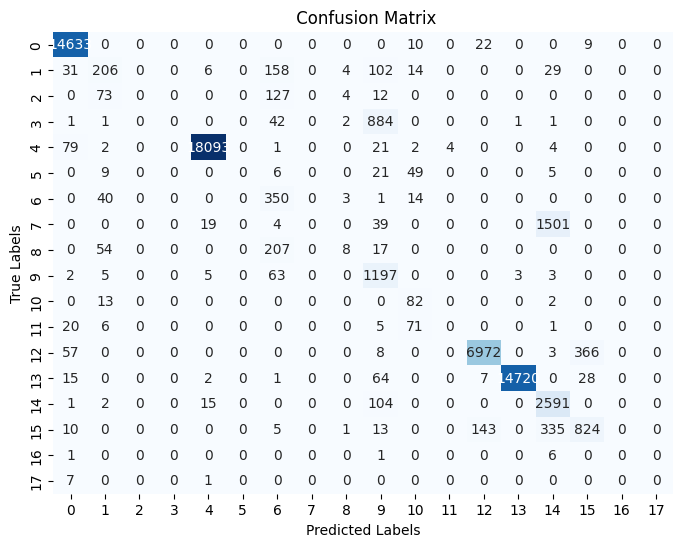

 ROC-AUC Score (multi-class OVR): 0.9906


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score, 
    roc_auc_score
)

# Convert test data to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Evaluate model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Move data to CPU for metric calculations
y_true = y_test_tensor.cpu().numpy()
y_pred = predicted.cpu().numpy()

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f" Final Test Accuracy: {test_accuracy:.4f}")

# Precision, Recall, F1 Score (macro, micro, weighted)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision (weighted): {precision:.4f}")
print(f" Recall (weighted): {recall:.4f}")
print(f" F1 Score (weighted): {f1:.4f}")

# Detailed Classification Report
report = classification_report(y_true, y_pred)
print("\n Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Optional: ROC-AUC Score
# Works for binary or multi-class (with probability outputs)
try:
    # Get probability scores if you have them
    probs = torch.softmax(outputs, dim=1).cpu().numpy()
    
    if len(np.unique(y_true)) == 2:
        roc_auc = roc_auc_score(y_true, probs[:, 1])
        print(f" ROC-AUC Score (binary): {roc_auc:.4f}")
    else:
        roc_auc = roc_auc_score(y_true, probs, multi_class='ovr')
        print(f" ROC-AUC Score (multi-class OVR): {roc_auc:.4f}")
except Exception as e:
    print(f" Could not compute ROC-AUC: {e}")


Save the Model

In [131]:
torch.save(model, "mlp_model_full.pth")
print("Full model saved as mlp_model_full.pth")


# loaded_model = torch.load("mlp_model_full.pth")
# loaded_model.eval()

# print("Full model loaded from mlp_model_full.pth")


Full model saved as mlp_model_full.pth


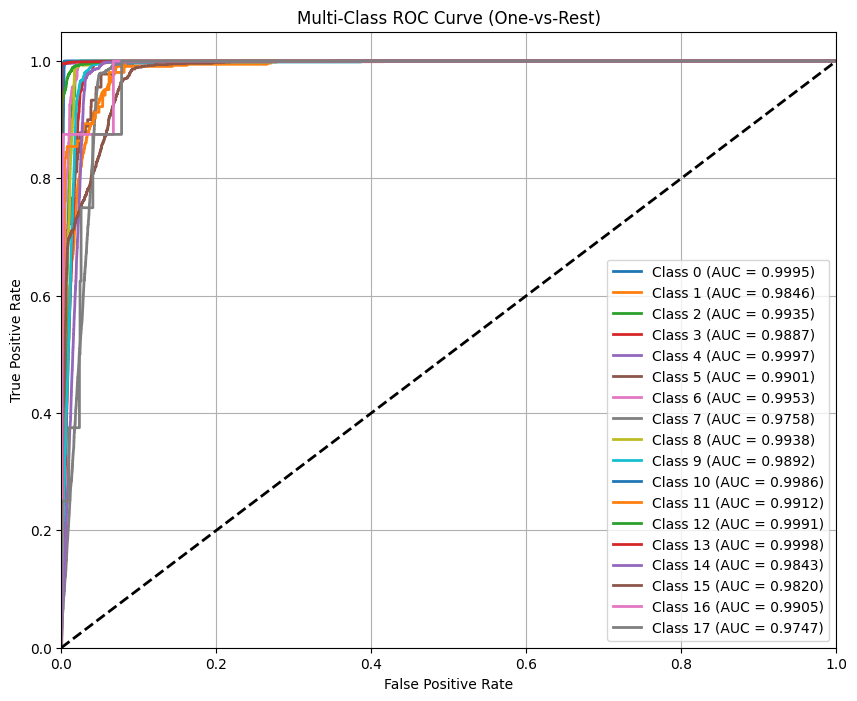

In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the true labels for multi-class ROC
classes = np.unique(y_true)
n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=classes)

# Get probabilities (softmaxed outputs)
probs = torch.softmax(outputs, dim=1).cpu().numpy()

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.4f})')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Decision Tree Training**

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

Please try to use tuned hyperparameter

In [42]:
# # Train Decision Tree Model
# dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
# dt_model.fit(X_train, y_train)

# # Evaluate on validation set
# y_val_pred = dt_model.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

# # Evaluate on test set
# y_test_pred = dt_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print("Classification Report:\n", classification_report(y_test, y_test_pred))

**Hyperparameter Tuning for Decision Tree**

In [1]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 20, 50],
    'min_samples_leaf': [5, 10, 20, 50]
}

# Grid Search
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the optimized Decision Tree
best_dt_model = DecisionTreeClassifier(**best_params, random_state=42)
best_dt_model.fit(X_train, y_train)

# Predictions
y_pred_best = best_dt_model.predict(X_test)

# Evaluation
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)
#print(f"Optimized Test Accuracy: {accuracy_best:.4f}")
#print("Optimized Classification Report:\n", report_best)



 Evaluating on Validation Set
 Accuracy: 0.9331
 Precision (weighted): 0.9297
 Recall (weighted):    0.9331
 F1 Score (weighted):  0.9260

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14675
           1       0.52      0.46      0.49       551
           2       0.34      0.13      0.19       216
           3       0.36      0.33      0.34       932
           4       1.00      1.00      1.00     18205
           5       0.16      0.11      0.13        89
           6       0.59      0.71      0.64       407
           7       0.37      0.05      0.09      1563
           8       0.41      0.50      0.45       286
           9       0.52      0.60      0.55      1279
          10       0.34      0.56      0.43        96
          11       0.38      0.27      0.32       103
          12       0.99      0.99      0.99      7406
          13       1.00      1.00      1.00     14838
          14       0.59 

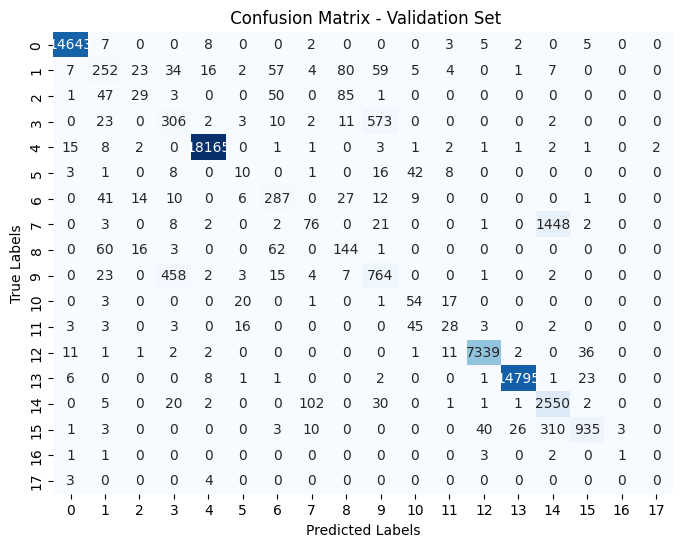

 ROC-AUC Score (Multi-Class OVR): 0.9935


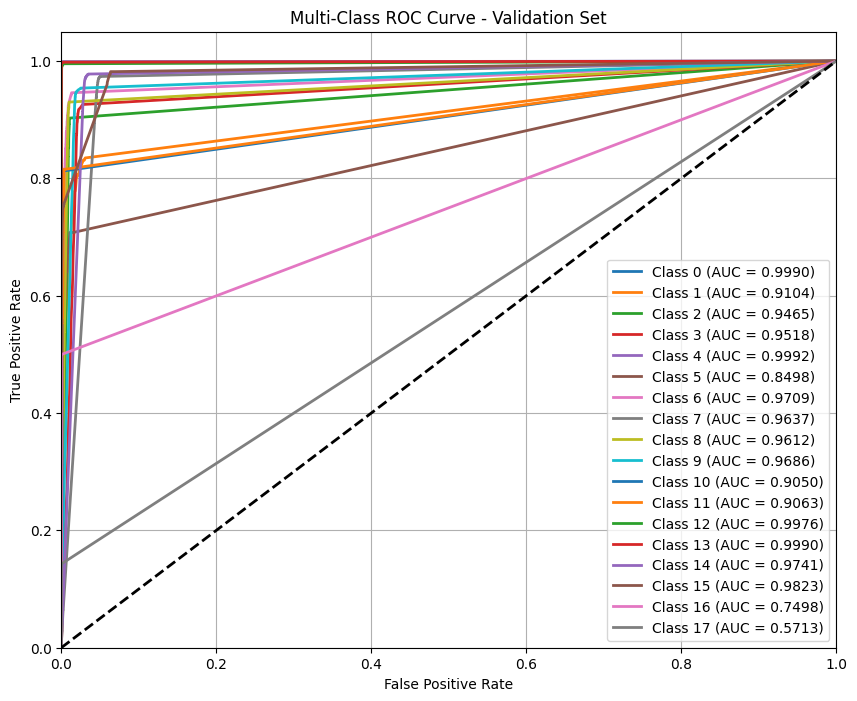


 Evaluating on Test Set
 Accuracy: 0.9345
 Precision (weighted): 0.9314
 Recall (weighted):    0.9345
 F1 Score (weighted):  0.9274

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14674
           1       0.56      0.51      0.53       550
           2       0.33      0.15      0.21       216
           3       0.39      0.35      0.37       932
           4       1.00      1.00      1.00     18206
           5       0.12      0.09      0.10        90
           6       0.62      0.71      0.66       408
           7       0.39      0.05      0.09      1563
           8       0.44      0.58      0.50       286
           9       0.52      0.61      0.56      1278
          10       0.36      0.56      0.43        97
          11       0.53      0.34      0.41       103
          12       0.99      0.99      0.99      7406
          13       1.00      1.00      1.00     14837
          14       0.59      0

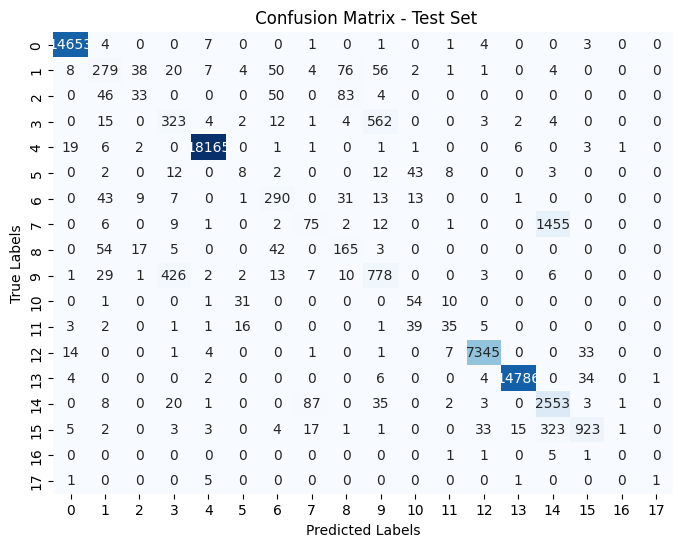

 ROC-AUC Score (Multi-Class OVR): 0.9932


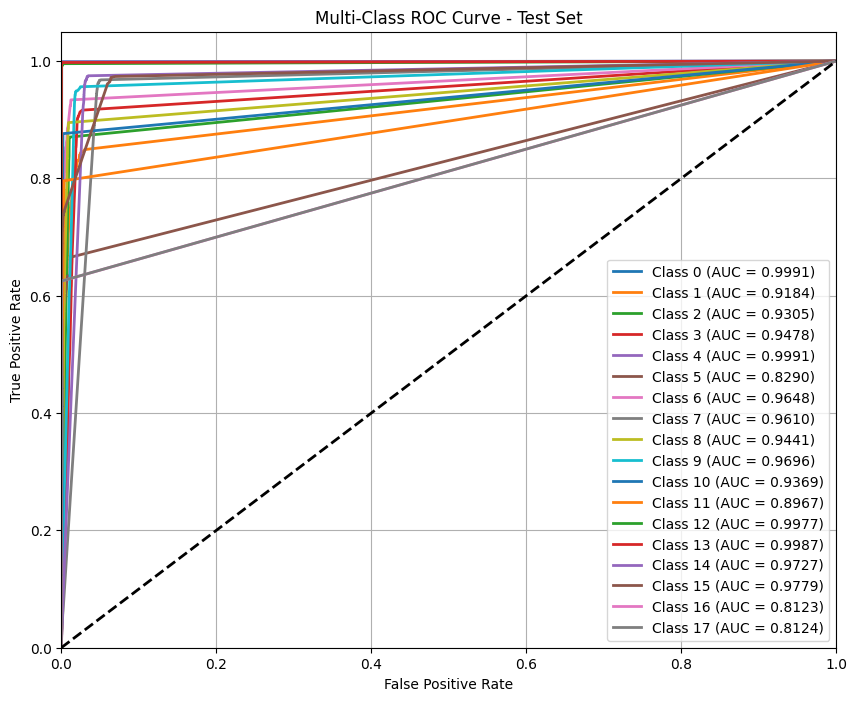

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize
import numpy as np

#Train Decision Tree Model
dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluation Function

def evaluate_model(model, X, y, dataset_name="Validation"):
    print(f"\n Evaluating on {dataset_name} Set")
    
    # Predict
    y_pred = model.predict(X)
    
    # Accuracy
    acc = accuracy_score(y, y_pred)
    print(f" Accuracy: {acc:.4f}")
    
    # Precision, Recall, F1 Scores
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    
    print(f" Precision (weighted): {precision:.4f}")
    print(f" Recall (weighted):    {recall:.4f}")
    print(f" F1 Score (weighted):  {f1:.4f}")
    
    # Full Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y, y_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f" Confusion Matrix - {dataset_name} Set")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # ROC-AUC and ROC Curve
    try:
        classes = np.unique(y)
        n_classes = len(classes)
        
        # Binarize y for ROC-AUC & Curve
        y_bin = label_binarize(y, classes=classes)
        y_pred_proba = model.predict_proba(X)
        
        if n_classes == 2:
            roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
            print(f" ROC-AUC Score (Binary): {roc_auc:.4f}")
            
            fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {dataset_name} Set')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
            
        else:
            roc_auc = roc_auc_score(y_bin, y_pred_proba, average='weighted', multi_class='ovr')
            print(f" ROC-AUC Score (Multi-Class OVR): {roc_auc:.4f}")
            
            plt.figure(figsize=(10, 8))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
                auc_score = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {auc_score:.4f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Multi-Class ROC Curve - {dataset_name} Set')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
            
    except Exception as e:
        print(f" ROC-AUC not computed: {e}")


# Evaluate on Validation Set
evaluate_model(dt_model, X_val, y_val, dataset_name="Validation")

# Evaluate on Test Set
evaluate_model(dt_model, X_test, y_test, dataset_name="Test")


Save the model

In [137]:
import joblib
# Save the trained Decision Tree model
joblib.dump(dt_model, 'decision_tree_model.joblib')

print(" Decision Tree model saved as decision_tree_model.joblib")

# Load the Decision Tree model
# loaded_dt_model = joblib.load('decision_tree_model.joblib')

 Decision Tree model saved as decision_tree_model.joblib


**Random Forest**

In [23]:
from sklearn.ensemble import RandomForestClassifier

**Hyperparameter tuning for RandomForest**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

In [141]:
# # Train Random Forest Model
# rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5,
#                                   min_samples_leaf=2, max_features='sqrt', random_state=42, n_jobs=-1)
# rf_model.fit(X_train, y_train)

# # Evaluate on validation set
# y_val_pred = rf_model.predict(X_val)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation Accuracy: {val_accuracy:.4f}")
# print("Classification Report:\n", classification_report(y_val, y_val_pred))

# # Evaluate on test set
# y_test_pred = rf_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print("Classification Report:\n", classification_report(y_test, y_test_pred))


 Evaluating on Validation Set
 Accuracy: 0.9363
 Precision (weighted): 0.9344
 Recall (weighted):    0.9363
 F1 Score (weighted):  0.9291

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14675
           1       0.62      0.46      0.53       551
           2       0.39      0.16      0.22       216
           3       0.37      0.29      0.32       932
           4       1.00      1.00      1.00     18205
           5       0.19      0.03      0.06        89
           6       0.59      0.77      0.67       407
           7       0.46      0.06      0.11      1563
           8       0.41      0.51      0.46       286
           9       0.52      0.66      0.58      1279
          10       0.37      0.64      0.47        96
          11       0.53      0.47      0.49       103
          12       1.00      0.99      0.99      7406
          13       1.00      1.00      1.00     14838
          14       0.59 

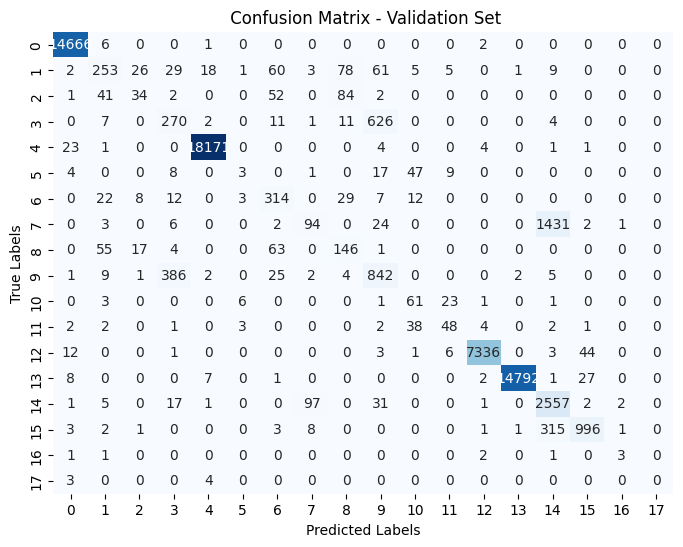

 ROC-AUC Score (Multi-Class OVR): 0.9981


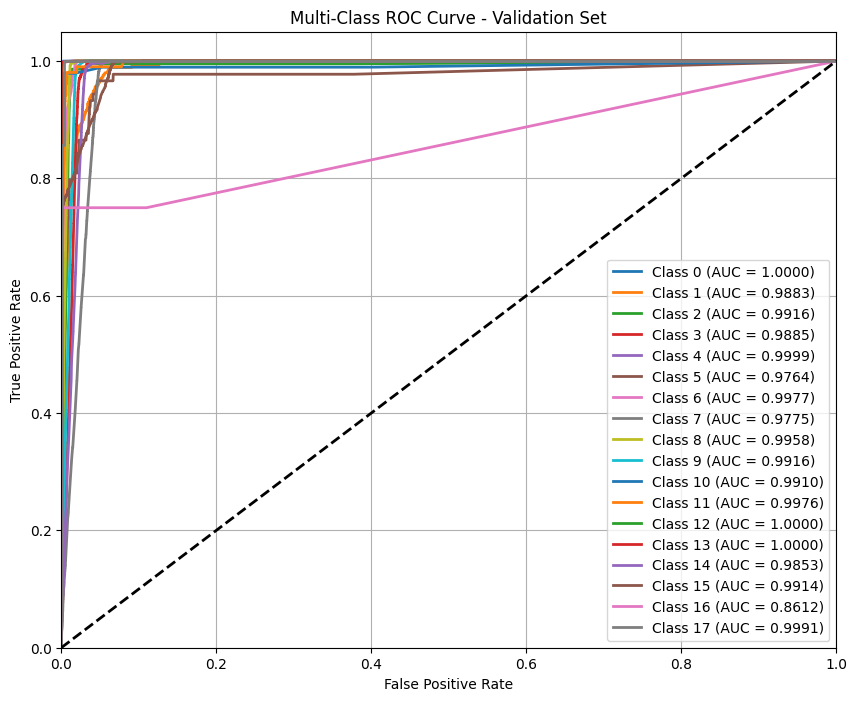


 Evaluating on Test Set
 Accuracy: 0.9373
 Precision (weighted): 0.9347
 Recall (weighted):    0.9373
 F1 Score (weighted):  0.9298

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14674
           1       0.65      0.51      0.57       550
           2       0.40      0.17      0.24       216
           3       0.39      0.29      0.33       932
           4       1.00      1.00      1.00     18206
           5       0.08      0.02      0.04        90
           6       0.63      0.77      0.69       408
           7       0.43      0.06      0.10      1563
           8       0.45      0.57      0.50       286
           9       0.53      0.68      0.60      1278
          10       0.43      0.72      0.54        97
          11       0.56      0.42      0.48       103
          12       1.00      0.99      0.99      7406
          13       1.00      1.00      1.00     14837
          14       0.59      0

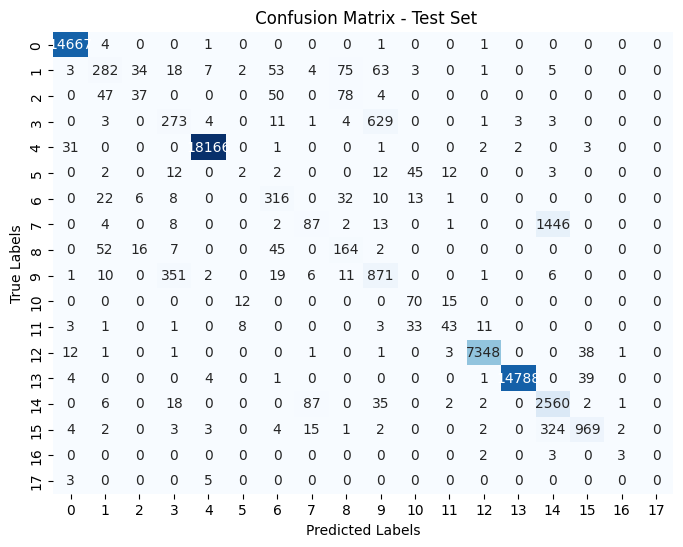

 ROC-AUC Score (Multi-Class OVR): 0.9981


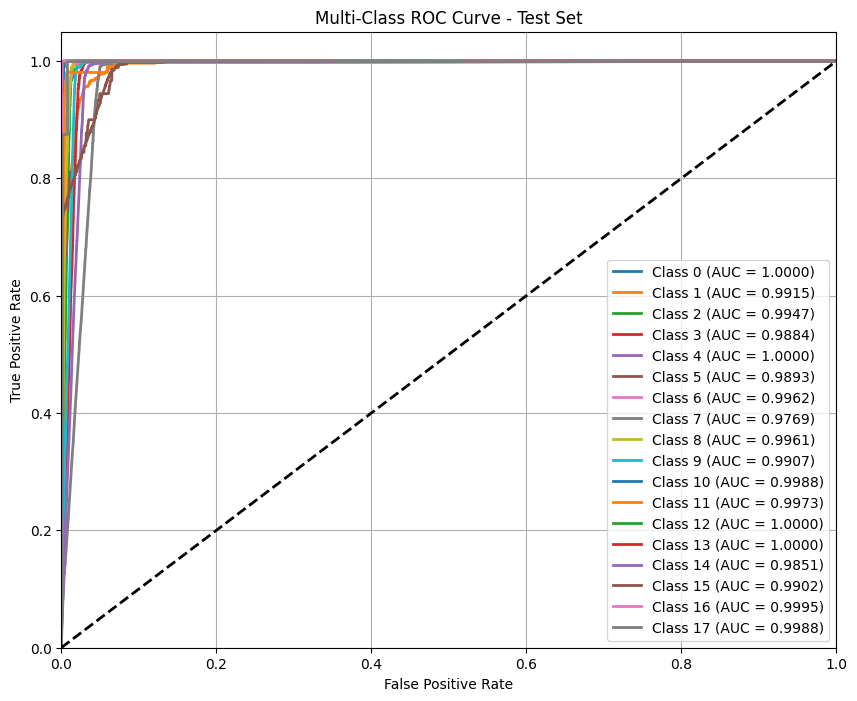

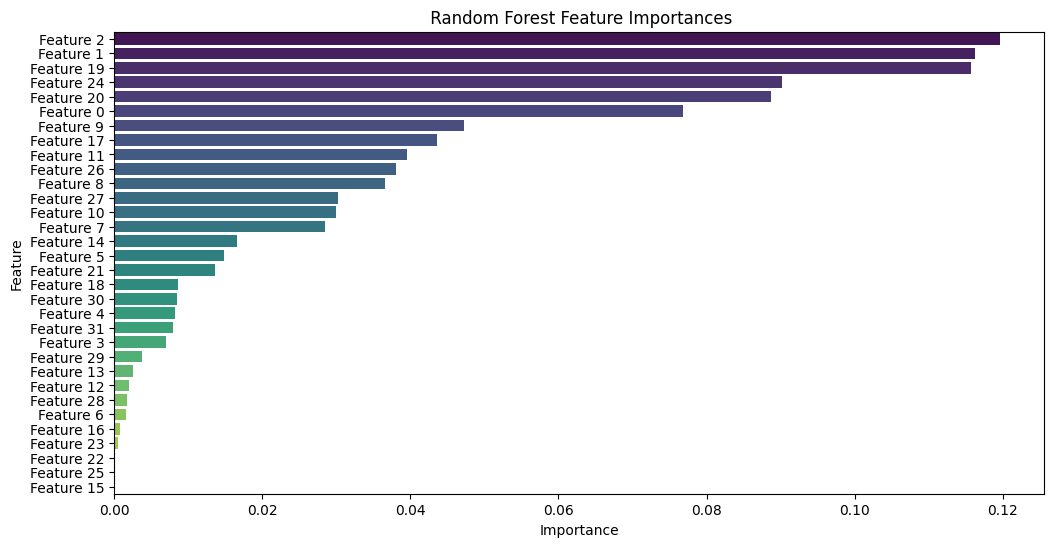

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import numpy as np

#Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=300,
   # max_depth=20,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Evaluation Function
def evaluate_rf_model(model, X, y, dataset_name="Validation"):
    print(f"\n Evaluating on {dataset_name} Set")
    
    # Predict
    y_pred = model.predict(X)
    
    # Accuracy
    acc = accuracy_score(y, y_pred)
    print(f" Accuracy: {acc:.4f}")
    
    # Precision, Recall, F1 Scores
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    
    print(f" Precision (weighted): {precision:.4f}")
    print(f" Recall (weighted):    {recall:.4f}")
    print(f" F1 Score (weighted):  {f1:.4f}")
    
    # Full Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y, y_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f" Confusion Matrix - {dataset_name} Set")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # ROC-AUC and ROC Curve
    try:
        classes = np.unique(y)
        n_classes = len(classes)
        
        # Binarize y for ROC-AUC & Curve
        y_bin = label_binarize(y, classes=classes)
        y_pred_proba = model.predict_proba(X)
        
        if n_classes == 2:
            roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
            print(f" ROC-AUC Score (Binary): {roc_auc:.4f}")
            
            fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {dataset_name} Set')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
            
        else:
            roc_auc = roc_auc_score(y_bin, y_pred_proba, average='weighted', multi_class='ovr')
            print(f" ROC-AUC Score (Multi-Class OVR): {roc_auc:.4f}")
            
            plt.figure(figsize=(10, 8))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
                auc_score = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {auc_score:.4f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Multi-Class ROC Curve - {dataset_name} Set')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
            
    except Exception as e:
        print(f" ROC-AUC not computed: {e}")


# Evaluate on Validation Set
evaluate_rf_model(rf_model, X_val, y_val, dataset_name="Validation")

#  Evaluate on Test Set
evaluate_rf_model(rf_model, X_test, y_test, dataset_name="Test")


# Feature Importance Plot

importances = rf_model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="viridis")
plt.title(" Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Save the model

In [142]:
import joblib
# Save the trained Random Forest model
joblib.dump(rf_model, 'random_forest_model.joblib')

print(" Random Forest model saved as random_forest_model.joblib")


# loaded_rf_model = joblib.load('random_forest_model.joblib')

 Random Forest model saved as random_forest_model.joblib


**Binary Classification using Random Forest **

In [27]:
import pandas as pd
import numpy as np
import glob
from sklearn.metrics import accuracy_score, classification_report

# Load dataset (change folder path)
DATA_FOLDER ="/kaggle/input/cicddos2019/" 
file_paths = glob.glob(f"{DATA_FOLDER}/*.parquet")
df_list = [pd.read_parquet(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)


###
# Convert Label to 'Benign' or 'Attack'
# df["Label"] = df["Label"].apply(lambda x: "Benign" if "Benign" in x else "Attack")

# Important features
# important_features = [
#     "Total Fwd Packets", "Total Backward Packets", "Fwd Packet Length Max",
#     "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max",
#     "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s",
#     "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max",
#     "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Min",
#     "Fwd PSH Flags", "Fwd URG Flags", "Fwd Packets/s", "Bwd Packets/s",
#     "Packet Length Min", "Packet Length Max", "Packet Length Mean",
#     "Packet Length Std", "SYN Flag Count", "CWE Flag Count",
#     "Avg Packet Size", "Avg Fwd Segment Size", "Bwd Avg Bytes/Bulk",
#     "Subflow Fwd Packets", "Subflow Bwd Packets", "Fwd Act Data Packets",
#     "Fwd Seg Size Min", "Active Mean", "Active Std", "Active Max",
#     "Idle Mean"
# ]

# Select only important features
# df_selected = df[important_features + ["Label"]]

# # Normalize features
# scaler = MinMaxScaler()
# df_selected[important_features] = scaler.fit_transform(df_selected[important_features])

# # Encode labels (Benign → 0, Attack → 1)
# df_selected["Label"] = df_selected["Label"].map({"Benign": 0, "Attack": 1})

# # Split into train, validation, and test sets
# X = df_selected[important_features].values
# y = df_selected["Label"].values
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# # Train Random Forest Classifier
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# rf_model.fit(X_train, y_train)

# # Predictions
# y_pred = rf_model.predict(X_test)

# # Evaluation
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")
# print("Classification Report:\n", report)


<ipython-input-7-7e7a904de888>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected[important_features] = scaler.fit_transform(df_selected[important_features])
<ipython-input-7-7e7a904de888>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["Label"] = df_selected["Label"].map({"Benign": 0, "Attack": 1})



 Evaluating on Validation Set
 Accuracy: 0.9991
 Precision: 0.9997
 Recall:    0.9991
 F1 Score:  0.9994

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14674
           1       1.00      1.00      1.00     50032

    accuracy                           1.00     64706
   macro avg       1.00      1.00      1.00     64706
weighted avg       1.00      1.00      1.00     64706



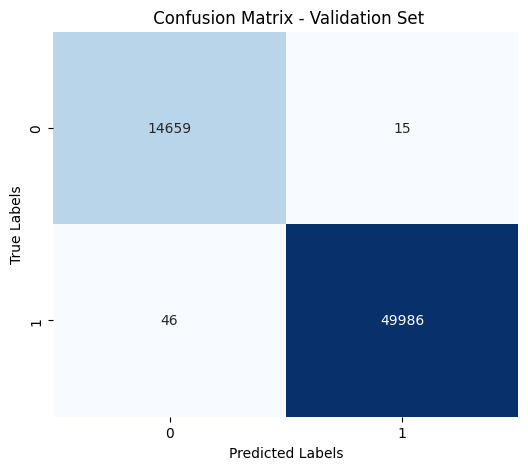

 ROC-AUC Score: 1.0000


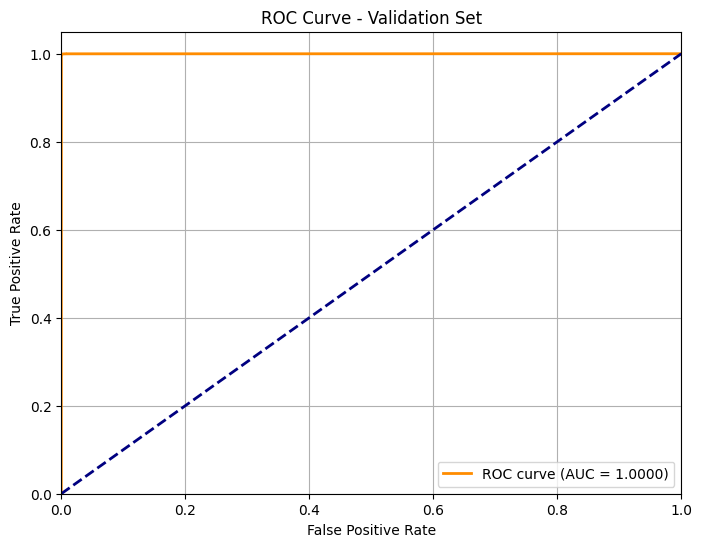


 Evaluating on Test Set
 Accuracy: 0.9993
 Precision: 0.9997
 Recall:    0.9994
 F1 Score:  0.9995

 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14675
           1       1.00      1.00      1.00     50031

    accuracy                           1.00     64706
   macro avg       1.00      1.00      1.00     64706
weighted avg       1.00      1.00      1.00     64706



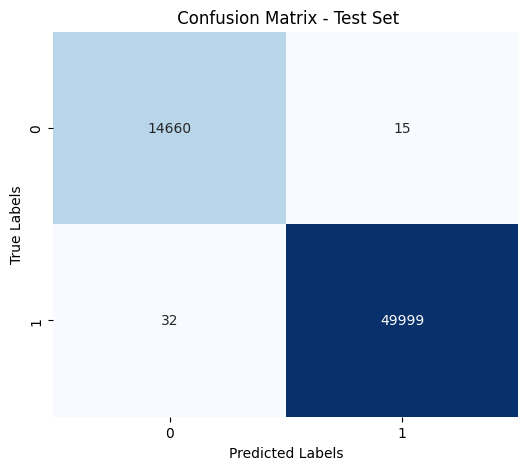

 ROC-AUC Score: 1.0000


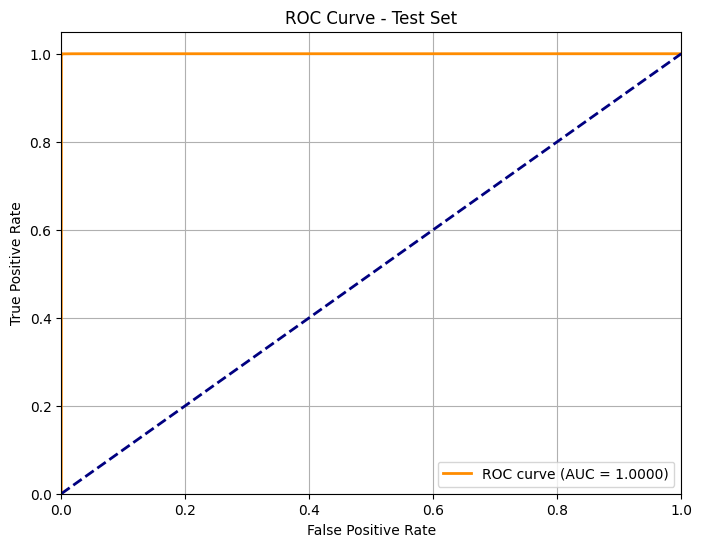

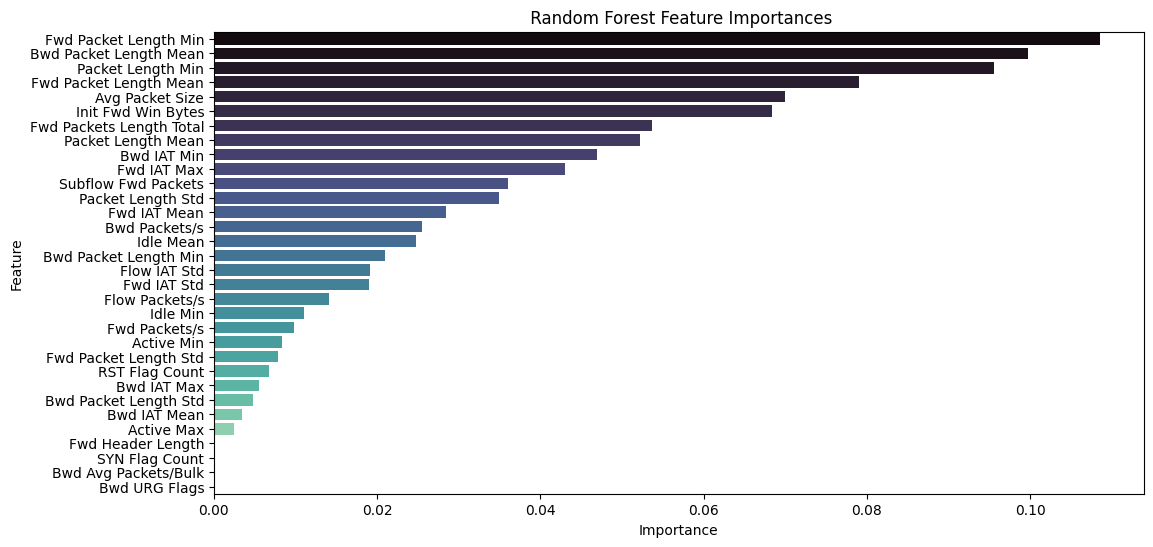

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

# Preprocessing

# Convert Label to 'Benign' or 'Attack'
df["Label"] = df["Label"].apply(lambda x: "Benign" if "Benign" in x else "Attack")

# Select only important features + Label
df_selected = df[important_features + ["Label"]]

# Normalize features
scaler = MinMaxScaler()
df_selected[important_features] = scaler.fit_transform(df_selected[important_features])


joblib.dump(scaler, "scaler.joblib")

# Encode labels (Benign → 0, Attack → 1)
df_selected["Label"] = df_selected["Label"].map({"Benign": 0, "Attack": 1})

# Split into train, validation, and test sets
X = df_selected[important_features].values
y = df_selected["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train Random Forest Classifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

#  Evaluation Function

def evaluate_binary_rf_model(model, X, y, dataset_name="Test"):
    print(f"\n Evaluating on {dataset_name} Set")
    
    # Predict
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]  # Probabilities for ROC
    
    # Accuracy
    acc = accuracy_score(y, y_pred)
    print(f" Accuracy: {acc:.4f}")
    
    # Precision, Recall, F1 Scores (Binary)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1 Score:  {f1:.4f}")
    
    # Full Classification Report
    print("\n Classification Report:\n")
    print(classification_report(y, y_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f" Confusion Matrix - {dataset_name} Set")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    # ROC-AUC and ROC Curve
    roc_auc = roc_auc_score(y, y_pred_proba)
    print(f" ROC-AUC Score: {roc_auc:.4f}")
    
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name} Set')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

#  Evaluate on Validation Set

evaluate_binary_rf_model(rf_model, X_val, y_val, dataset_name="Validation")

#  Evaluate on Test Set

evaluate_binary_rf_model(rf_model, X_test, y_test, dataset_name="Test")

#  Feature Importance Plot

importances = rf_model.feature_importances_

# If you have the feature names
feature_names = important_features

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette="mako")
plt.title(" Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [145]:
import joblib
# Save the trained Random Forest model
joblib.dump(rf_model, 'random_forest_model_binary.joblib')

print(" Random Forest binary model saved as random_forest_model.joblib")


# loaded_rf_model = joblib.load('random_forest_model.joblib')

 Random Forest binary model saved as random_forest_model.joblib


**Rule Based IDS binary classification**

In [8]:
def detect_attack(sample):
    # Sample is a dictionary of feature values
    if sample[19] <= 0.0540:
        if sample[9] <= 0.0756:
            if sample[24] <= 0.0019:
                if sample[19] <= 0.0010:
                    if sample[18] <= 0.0077:
                        if sample[11] <= 0.0858:
                            if sample[27] <= 0.1240:
                                if sample[27] <= 0.0887:
                                    if sample[27] <= 0.0038:
                                        if sample[27] <= 0.0038:
                                            return 0
                                        else:  # Init Fwd Win Bytes > 0.0038
                                            return 0
                                    else:  # Init Fwd Win Bytes > 0.0038
                                        if sample[13] <= 0.0000:
                                            return 0
                                        else:  # Bwd IAT Max > 0.0000
                                            return 0
                                else:  # Init Fwd Win Bytes > 0.0887
                                    if sample[27] <= 0.0897:
                                        return 1
                                    else:  # Init Fwd Win Bytes > 0.0897
                                        if sample[27] <= 0.0995:
                                            return 0
                                        else:  # Init Fwd Win Bytes > 0.0995
                                            return 0
                            else:  # Init Fwd Win Bytes > 0.1240
                                if sample[27] <= 0.9998:
                                    if sample[4] <= 0.0021:
                                        if sample[17] <= 0.0022:
                                            return 0
                                        else:  # Fwd Packets/s > 0.0022
                                            return 0
                                    else:  # Bwd Packet Length Min > 0.0021
                                        if sample[7] <= 0.0000:
                                            return 0
                                        else:  # Flow Packets/s > 0.0000
                                            return 0
                                else:  # Init Fwd Win Bytes > 0.9998
                                    return 1
                        else:  # Fwd IAT Max > 0.0858
                            if sample[27] <= 0.0446:
                                if sample[10] <= 0.0731:
                                    return 1
                                else:  # Fwd IAT Std > 0.0731
                                    return 0
                            else:  # Init Fwd Win Bytes > 0.0446
                                if sample[10] <= 0.0757:
                                    return 1
                                else:  # Fwd IAT Std > 0.0757
                                    return 1
                    else:  # Bwd Packets/s > 0.0077
                        if sample[27] <= 0.0877:
                            if sample[27] <= 0.0010:
                                if sample[27] <= 0.0010:
                                    if sample[27] <= 0.0001:
                                        return 0
                                    else:  # Init Fwd Win Bytes > 0.0001
                                        return 0
                                else:  # Init Fwd Win Bytes > 0.0010
                                    return 1
                            else:  # Init Fwd Win Bytes > 0.0010
                                if sample[27] <= 0.0037:
                                    if sample[27] <= 0.0022:
                                        return 0
                                    else:  # Init Fwd Win Bytes > 0.0022
                                        if sample[27] <= 0.0035:
                                            return 0
                                        else:  # Init Fwd Win Bytes > 0.0035
                                            return 0
                                else:  # Init Fwd Win Bytes > 0.0037
                                    if sample[26] <= 0.0000:
                                        if sample[14] <= 0.0100:
                                            return 0
                                        else:  # Bwd IAT Min > 0.0100
                                            return 0
                                    else:  # Subflow Fwd Packets > 0.0000
                                        if sample[27] <= 0.0157:
                                            return 0
                                        else:  # Init Fwd Win Bytes > 0.0157
                                            return 0
                        else:  # Init Fwd Win Bytes > 0.0877
                            if sample[27] <= 0.0897:
                                return 1
                            else:  # Init Fwd Win Bytes > 0.0897
                                if sample[27] <= 0.3802:
                                    return 0
                                else:  # Init Fwd Win Bytes > 0.3802
                                    if sample[17] <= 0.0026:
                                        return 0
                                    else:  # Fwd Packets/s > 0.0026
                                        return 1
                else:  # Packet Length Min > 0.0010
                    if sample[27] <= 0.0860:
                        if sample[24] <= 0.0018:
                            if sample[27] <= 0.0101:
                                if sample[8] <= 0.0000:
                                    return 0
                                else:  # Flow IAT Std > 0.0000
                                    return 0
                            else:  # Init Fwd Win Bytes > 0.0101
                                return 1
                        else:  # Avg Packet Size > 0.0018
                            if sample[17] <= 0.0030:
                                return 0
                            else:  # Fwd Packets/s > 0.0030
                                if sample[27] <= 0.0145:
                                    return 0
                                else:  # Init Fwd Win Bytes > 0.0145
                                    return 0
                    else:  # Init Fwd Win Bytes > 0.0860
                        if sample[27] <= 0.0896:
                            return 1
                        else:  # Init Fwd Win Bytes > 0.0896
                            if sample[17] <= 0.0018:
                                return 0
                            else:  # Fwd Packets/s > 0.0018
                                if sample[27] <= 0.4516:
                                    if sample[17] <= 0.0050:
                                        return 1
                                    else:  # Fwd Packets/s > 0.0050
                                        return 1
                                else:  # Init Fwd Win Bytes > 0.4516
                                    return 1
            else:  # Avg Packet Size > 0.0019
                if sample[27] <= 0.9998:
                    if sample[17] <= 0.0049:
                        if sample[9] <= 0.0022:
                            if sample[8] <= 0.0000:
                                if sample[18] <= 0.0000:
                                    if sample[7] <= 0.0031:
                                        return 1
                                    else:  # Flow Packets/s > 0.0031
                                        return 1
                                else:  # Bwd Packets/s > 0.0000
                                    if sample[4] <= 0.0021:
                                        return 0
                                    else:  # Bwd Packet Length Min > 0.0021
                                        return 0
                            else:  # Flow IAT Std > 0.0000
                                if sample[8] <= 0.0553:
                                    if sample[18] <= 0.0002:
                                        if sample[17] <= 0.0000:
                                            return 0
                                        else:  # Fwd Packets/s > 0.0000
                                            return 0
                                    else:  # Bwd Packets/s > 0.0002
                                        if sample[13] <= 0.0000:
                                            return 0
                                        else:  # Bwd IAT Max > 0.0000
                                            return 0
                                else:  # Flow IAT Std > 0.0553
                                    return 0
                        else:  # Fwd IAT Mean > 0.0022
                            if sample[11] <= 0.0336:
                                if sample[26] <= 0.0002:
                                    if sample[8] <= 0.0153:
                                        if sample[23] <= 0.5000:
                                            return 0
                                        else:  # RST Flag Count > 0.5000
                                            return 0
                                    else:  # Flow IAT Std > 0.0153
                                        if sample[20] <= 0.0708:
                                            return 0
                                        else:  # Packet Length Mean > 0.0708
                                            return 1
                                else:  # Subflow Fwd Packets > 0.0002
                                    if sample[13] <= 0.0252:
                                        if sample[13] <= 0.0120:
                                            return 0
                                        else:  # Bwd IAT Max > 0.0120
                                            return 1
                                    else:  # Bwd IAT Max > 0.0252
                                        return 0
                            else:  # Fwd IAT Max > 0.0336
                                if sample[8] <= 0.0093:
                                    return 0
                                else:  # Flow IAT Std > 0.0093
                                    if sample[5] <= 0.0048:
                                        if sample[29] <= 0.0005:
                                            return 0
                                        else:  # Active Min > 0.0005
                                            return 0
                                    else:  # Bwd Packet Length Mean > 0.0048
                                        if sample[28] <= 0.3118:
                                            return 0
                                        else:  # Active Max > 0.3118
                                            return 0
                    else:  # Fwd Packets/s > 0.0049
                        if sample[27] <= 0.0000:
                            if sample[0] <= 0.0000:
                                if sample[0] <= 0.0000:
                                    if sample[1] <= 0.0115:
                                        return 1
                                    else:  # Fwd Packet Length Min > 0.0115
                                        return 1
                                else:  # Fwd Packets Length Total > 0.0000
                                    if sample[2] <= 0.0114:
                                        if sample[24] <= 0.0117:
                                            return 0
                                        else:  # Avg Packet Size > 0.0117
                                            return 0
                                    else:  # Fwd Packet Length Mean > 0.0114
                                        if sample[17] <= 0.0117:
                                            return 1
                                        else:  # Fwd Packets/s > 0.0117
                                            return 1
                            else:  # Fwd Packets Length Total > 0.0000
                                if sample[24] <= 0.0183:
                                    return 0
                                else:  # Avg Packet Size > 0.0183
                                    return 1
                        else:  # Init Fwd Win Bytes > 0.0000
                            if sample[7] <= 0.1036:
                                if sample[0] <= 0.0000:
                                    if sample[27] <= 0.0778:
                                        return 0
                                    else:  # Init Fwd Win Bytes > 0.0778
                                        if sample[27] <= 0.1226:
                                            return 1
                                        else:  # Init Fwd Win Bytes > 0.1226
                                            return 0
                                else:  # Fwd Packets Length Total > 0.0000
                                    return 0
                            else:  # Flow Packets/s > 0.1036
                                if sample[22] <= 0.5000:
                                    if sample[7] <= 0.1531:
                                        if sample[27] <= 0.0778:
                                            return 0
                                        else:  # Init Fwd Win Bytes > 0.0778
                                            return 0
                                    else:  # Flow Packets/s > 0.1531
                                        if sample[19] <= 0.0231:
                                            return 0
                                        else:  # Packet Length Min > 0.0231
                                            return 0
                                else:  # SYN Flag Count > 0.5000
                                    if sample[7] <= 0.4167:
                                        return 0
                                    else:  # Flow Packets/s > 0.4167
                                        return 0
                else:  # Init Fwd Win Bytes > 0.9998
                    if sample[2] <= 0.0267:
                        if sample[18] <= 0.0008:
                            return 0
                        else:  # Bwd Packets/s > 0.0008
                            return 0
                    else:  # Fwd Packet Length Mean > 0.0267
                        if sample[0] <= 0.0001:
                            return 1
                        else:  # Fwd Packets Length Total > 0.0001
                            return 0
        else:  # Fwd IAT Mean > 0.0756
            if sample[21] <= 0.0000:
                if sample[27] <= 0.0556:
                    if sample[26] <= 0.0000:
                        if sample[20] <= 0.0007:
                            return 0
                        else:  # Packet Length Mean > 0.0007
                            return 0
                    else:  # Subflow Fwd Packets > 0.0000
                        return 0
                else:  # Init Fwd Win Bytes > 0.0556
                    if sample[27] <= 0.1678:
                        return 1
                    else:  # Init Fwd Win Bytes > 0.1678
                        if sample[27] <= 0.9716:
                            return 0
                        else:  # Init Fwd Win Bytes > 0.9716
                            return 1
            else:  # Packet Length Std > 0.0000
                if sample[29] <= 0.0000:
                    if sample[30] <= 0.0856:
                        if sample[12] <= 0.0000:
                            return 0
                        else:  # Bwd IAT Mean > 0.0000
                            return 0
                    else:  # Idle Mean > 0.0856
                        if sample[10] <= 0.1137:
                            return 1
                        else:  # Fwd IAT Std > 0.1137
                            return 0
                else:  # Active Min > 0.0000
                    return 0
    else:  # Packet Length Min > 0.0540
        if sample[24] <= 0.0421:
            if sample[21] <= 0.0001:
                if sample[2] <= 0.0378:
                    if sample[19] <= 0.0560:
                        return 1
                    else:  # Packet Length Min > 0.0560
                        if sample[17] <= 0.3750:
                            return 1
                        else:  # Fwd Packets/s > 0.3750
                            return 1
                else:  # Fwd Packet Length Mean > 0.0378
                    return 0
            else:  # Packet Length Std > 0.0001
                return 0
        else:  # Avg Packet Size > 0.0421
            if sample[9] <= 0.0408:
                if sample[24] <= 0.0627:
                    if sample[24] <= 0.0623:
                        if sample[24] <= 0.0474:
                            if sample[2] <= 0.0405:
                                return 1
                            else:  # Fwd Packet Length Mean > 0.0405
                                return 0
                        else:  # Avg Packet Size > 0.0474
                            if sample[2] <= 0.0542:
                                if sample[2] <= 0.0509:
                                    return 1
                                else:  # Fwd Packet Length Mean > 0.0509
                                    return 1
                            else:  # Fwd Packet Length Mean > 0.0542
                                return 1
                    else:  # Avg Packet Size > 0.0623
                        return 0
                else:  # Avg Packet Size > 0.0627
                    if sample[4] <= 0.1027:
                        if sample[2] <= 0.0660:
                            if sample[20] <= 0.0476:
                                return 1
                            else:  # Packet Length Mean > 0.0476
                                if sample[17] <= 0.3750:
                                    return 1
                                else:  # Fwd Packets/s > 0.3750
                                    return 1
                        else:  # Fwd Packet Length Mean > 0.0660
                            if sample[21] <= 0.0294:
                                if sample[0] <= 0.0000:
                                    if sample[20] <= 0.0782:
                                        if sample[20] <= 0.0630:
                                            return 1
                                        else:  # Packet Length Mean > 0.0630
                                            return 1
                                    else:  # Packet Length Mean > 0.0782
                                        return 1
                                else:  # Fwd Packets Length Total > 0.0000
                                    if sample[2] <= 0.4880:
                                        return 1
                                    else:  # Fwd Packet Length Mean > 0.4880
                                        if sample[0] <= 0.0004:
                                            return 1
                                        else:  # Fwd Packets Length Total > 0.0004
                                            return 1
                            else:  # Packet Length Std > 0.0294
                                if sample[7] <= 0.2917:
                                    return 1
                                else:  # Flow Packets/s > 0.2917
                                    return 1
                    else:  # Bwd Packet Length Min > 0.1027
                        return 1
            else:  # Fwd IAT Mean > 0.0408
                if sample[11] <= 0.1853:
                    if sample[9] <= 0.0675:
                        if sample[11] <= 0.0262:
                            return 0
                        else:  # Fwd IAT Max > 0.0262
                            return 1
                    else:  # Fwd IAT Mean > 0.0675
                        if sample[30] <= 0.0546:
                            return 0
                        else:  # Idle Mean > 0.0546
                            return 0
                else:  # Fwd IAT Max > 0.1853
                    return 1


 Accuracy: 0.9969
 Precision: 0.9996
 Recall: 0.9965
 F1 Score: 0.9980

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     14675
           1       1.00      1.00      1.00     50031

    accuracy                           1.00     64706
   macro avg       0.99      1.00      1.00     64706
weighted avg       1.00      1.00      1.00     64706



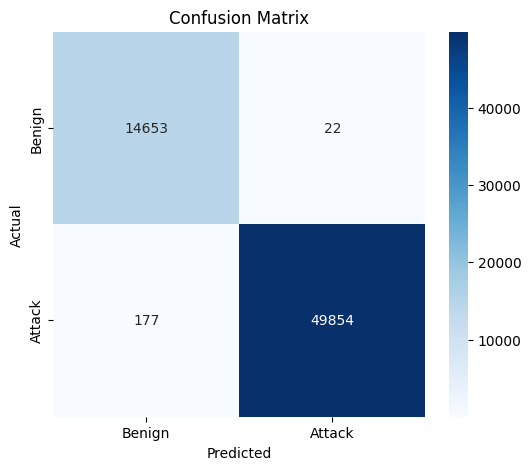

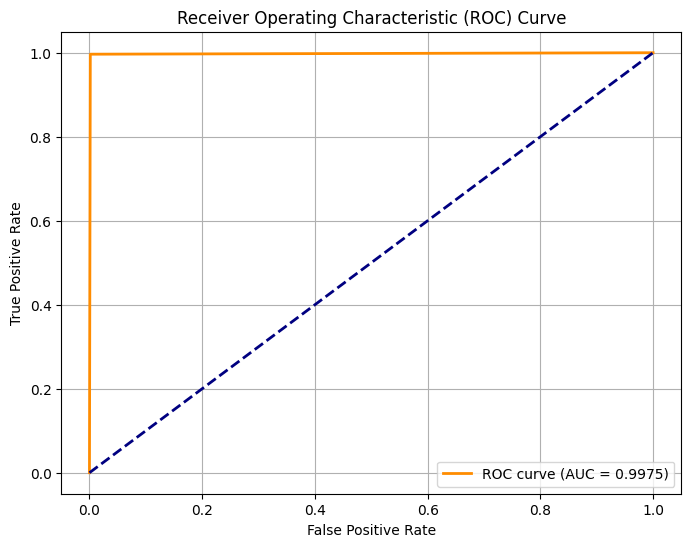

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# Assuming detect_attack returns 0 (Benign) or 1 (Attack)
y_pred = []
for sample in X_test:
    prediction = detect_attack(sample)
    y_pred.append(prediction)

y_pred = np.array(y_pred)


#  EVALUATION METRICS

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f" Accuracy: {acc:.4f}")
print(f" Precision: {prec:.4f}")
print(f" Recall: {rec:.4f}")
print(f" F1 Score: {f1:.4f}")
print("\n Classification Report:\n", report)


#  CONFUSION MATRIX (PLOT)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Pipeline for End to End

In [3]:
# def detect_attack(sample):
#     # Sample is a dictionary of feature values
#     if sample[19] <= 0.0540:
#         if sample[9] <= 0.0756:
#             if sample[24] <= 0.0019:
#                 if sample[19] <= 0.0010:
#                     if sample[18] <= 0.0077:
#                         if sample[11] <= 0.0858:
#                             if sample[27] <= 0.1240:
#                                 if sample[27] <= 0.0887:
#                                     if sample[27] <= 0.0038:
#                                         if sample[27] <= 0.0038:
#                                             return 0
#                                         else:  # Init Fwd Win Bytes > 0.0038
#                                             return 0
#                                     else:  # Init Fwd Win Bytes > 0.0038
#                                         if sample[13] <= 0.0000:
#                                             return 0
#                                         else:  # Bwd IAT Max > 0.0000
#                                             return 0
#                                 else:  # Init Fwd Win Bytes > 0.0887
#                                     if sample[27] <= 0.0897:
#                                         return 1
#                                     else:  # Init Fwd Win Bytes > 0.0897
#                                         if sample[27] <= 0.0995:
#                                             return 0
#                                         else:  # Init Fwd Win Bytes > 0.0995
#                                             return 0
#                             else:  # Init Fwd Win Bytes > 0.1240
#                                 if sample[27] <= 0.9998:
#                                     if sample[4] <= 0.0021:
#                                         if sample[17] <= 0.0022:
#                                             return 0
#                                         else:  # Fwd Packets/s > 0.0022
#                                             return 0
#                                     else:  # Bwd Packet Length Min > 0.0021
#                                         if sample[7] <= 0.0000:
#                                             return 0
#                                         else:  # Flow Packets/s > 0.0000
#                                             return 0
#                                 else:  # Init Fwd Win Bytes > 0.9998
#                                     return 1
#                         else:  # Fwd IAT Max > 0.0858
#                             if sample[27] <= 0.0446:
#                                 if sample[10] <= 0.0731:
#                                     return 1
#                                 else:  # Fwd IAT Std > 0.0731
#                                     return 0
#                             else:  # Init Fwd Win Bytes > 0.0446
#                                 if sample[10] <= 0.0757:
#                                     return 1
#                                 else:  # Fwd IAT Std > 0.0757
#                                     return 1
#                     else:  # Bwd Packets/s > 0.0077
#                         if sample[27] <= 0.0877:
#                             if sample[27] <= 0.0010:
#                                 if sample[27] <= 0.0010:
#                                     if sample[27] <= 0.0001:
#                                         return 0
#                                     else:  # Init Fwd Win Bytes > 0.0001
#                                         return 0
#                                 else:  # Init Fwd Win Bytes > 0.0010
#                                     return 1
#                             else:  # Init Fwd Win Bytes > 0.0010
#                                 if sample[27] <= 0.0037:
#                                     if sample[27] <= 0.0022:
#                                         return 0
#                                     else:  # Init Fwd Win Bytes > 0.0022
#                                         if sample[27] <= 0.0035:
#                                             return 0
#                                         else:  # Init Fwd Win Bytes > 0.0035
#                                             return 0
#                                 else:  # Init Fwd Win Bytes > 0.0037
#                                     if sample[26] <= 0.0000:
#                                         if sample[14] <= 0.0100:
#                                             return 0
#                                         else:  # Bwd IAT Min > 0.0100
#                                             return 0
#                                     else:  # Subflow Fwd Packets > 0.0000
#                                         if sample[27] <= 0.0157:
#                                             return 0
#                                         else:  # Init Fwd Win Bytes > 0.0157
#                                             return 0
#                         else:  # Init Fwd Win Bytes > 0.0877
#                             if sample[27] <= 0.0897:
#                                 return 1
#                             else:  # Init Fwd Win Bytes > 0.0897
#                                 if sample[27] <= 0.3802:
#                                     return 0
#                                 else:  # Init Fwd Win Bytes > 0.3802
#                                     if sample[17] <= 0.0026:
#                                         return 0
#                                     else:  # Fwd Packets/s > 0.0026
#                                         return 1
#                 else:  # Packet Length Min > 0.0010
#                     if sample[27] <= 0.0860:
#                         if sample[24] <= 0.0018:
#                             if sample[27] <= 0.0101:
#                                 if sample[8] <= 0.0000:
#                                     return 0
#                                 else:  # Flow IAT Std > 0.0000
#                                     return 0
#                             else:  # Init Fwd Win Bytes > 0.0101
#                                 return 1
#                         else:  # Avg Packet Size > 0.0018
#                             if sample[17] <= 0.0030:
#                                 return 0
#                             else:  # Fwd Packets/s > 0.0030
#                                 if sample[27] <= 0.0145:
#                                     return 0
#                                 else:  # Init Fwd Win Bytes > 0.0145
#                                     return 0
#                     else:  # Init Fwd Win Bytes > 0.0860
#                         if sample[27] <= 0.0896:
#                             return 1
#                         else:  # Init Fwd Win Bytes > 0.0896
#                             if sample[17] <= 0.0018:
#                                 return 0
#                             else:  # Fwd Packets/s > 0.0018
#                                 if sample[27] <= 0.4516:
#                                     if sample[17] <= 0.0050:
#                                         return 1
#                                     else:  # Fwd Packets/s > 0.0050
#                                         return 1
#                                 else:  # Init Fwd Win Bytes > 0.4516
#                                     return 1
#             else:  # Avg Packet Size > 0.0019
#                 if sample[27] <= 0.9998:
#                     if sample[17] <= 0.0049:
#                         if sample[9] <= 0.0022:
#                             if sample[8] <= 0.0000:
#                                 if sample[18] <= 0.0000:
#                                     if sample[7] <= 0.0031:
#                                         return 1
#                                     else:  # Flow Packets/s > 0.0031
#                                         return 1
#                                 else:  # Bwd Packets/s > 0.0000
#                                     if sample[4] <= 0.0021:
#                                         return 0
#                                     else:  # Bwd Packet Length Min > 0.0021
#                                         return 0
#                             else:  # Flow IAT Std > 0.0000
#                                 if sample[8] <= 0.0553:
#                                     if sample[18] <= 0.0002:
#                                         if sample[17] <= 0.0000:
#                                             return 0
#                                         else:  # Fwd Packets/s > 0.0000
#                                             return 0
#                                     else:  # Bwd Packets/s > 0.0002
#                                         if sample[13] <= 0.0000:
#                                             return 0
#                                         else:  # Bwd IAT Max > 0.0000
#                                             return 0
#                                 else:  # Flow IAT Std > 0.0553
#                                     return 0
#                         else:  # Fwd IAT Mean > 0.0022
#                             if sample[11] <= 0.0336:
#                                 if sample[26] <= 0.0002:
#                                     if sample[8] <= 0.0153:
#                                         if sample[23] <= 0.5000:
#                                             return 0
#                                         else:  # RST Flag Count > 0.5000
#                                             return 0
#                                     else:  # Flow IAT Std > 0.0153
#                                         if sample[20] <= 0.0708:
#                                             return 0
#                                         else:  # Packet Length Mean > 0.0708
#                                             return 1
#                                 else:  # Subflow Fwd Packets > 0.0002
#                                     if sample[13] <= 0.0252:
#                                         if sample[13] <= 0.0120:
#                                             return 0
#                                         else:  # Bwd IAT Max > 0.0120
#                                             return 1
#                                     else:  # Bwd IAT Max > 0.0252
#                                         return 0
#                             else:  # Fwd IAT Max > 0.0336
#                                 if sample[8] <= 0.0093:
#                                     return 0
#                                 else:  # Flow IAT Std > 0.0093
#                                     if sample[5] <= 0.0048:
#                                         if sample[29] <= 0.0005:
#                                             return 0
#                                         else:  # Active Min > 0.0005
#                                             return 0
#                                     else:  # Bwd Packet Length Mean > 0.0048
#                                         if sample[28] <= 0.3118:
#                                             return 0
#                                         else:  # Active Max > 0.3118
#                                             return 0
#                     else:  # Fwd Packets/s > 0.0049
#                         if sample[27] <= 0.0000:
#                             if sample[0] <= 0.0000:
#                                 if sample[0] <= 0.0000:
#                                     if sample[1] <= 0.0115:
#                                         return 1
#                                     else:  # Fwd Packet Length Min > 0.0115
#                                         return 1
#                                 else:  # Fwd Packets Length Total > 0.0000
#                                     if sample[2] <= 0.0114:
#                                         if sample[24] <= 0.0117:
#                                             return 0
#                                         else:  # Avg Packet Size > 0.0117
#                                             return 0
#                                     else:  # Fwd Packet Length Mean > 0.0114
#                                         if sample[17] <= 0.0117:
#                                             return 1
#                                         else:  # Fwd Packets/s > 0.0117
#                                             return 1
#                             else:  # Fwd Packets Length Total > 0.0000
#                                 if sample[24] <= 0.0183:
#                                     return 0
#                                 else:  # Avg Packet Size > 0.0183
#                                     return 1
#                         else:  # Init Fwd Win Bytes > 0.0000
#                             if sample[7] <= 0.1036:
#                                 if sample[0] <= 0.0000:
#                                     if sample[27] <= 0.0778:
#                                         return 0
#                                     else:  # Init Fwd Win Bytes > 0.0778
#                                         if sample[27] <= 0.1226:
#                                             return 1
#                                         else:  # Init Fwd Win Bytes > 0.1226
#                                             return 0
#                                 else:  # Fwd Packets Length Total > 0.0000
#                                     return 0
#                             else:  # Flow Packets/s > 0.1036
#                                 if sample[22] <= 0.5000:
#                                     if sample[7] <= 0.1531:
#                                         if sample[27] <= 0.0778:
#                                             return 0
#                                         else:  # Init Fwd Win Bytes > 0.0778
#                                             return 0
#                                     else:  # Flow Packets/s > 0.1531
#                                         if sample[19] <= 0.0231:
#                                             return 0
#                                         else:  # Packet Length Min > 0.0231
#                                             return 0
#                                 else:  # SYN Flag Count > 0.5000
#                                     if sample[7] <= 0.4167:
#                                         return 0
#                                     else:  # Flow Packets/s > 0.4167
#                                         return 0
#                 else:  # Init Fwd Win Bytes > 0.9998
#                     if sample[2] <= 0.0267:
#                         if sample[18] <= 0.0008:
#                             return 0
#                         else:  # Bwd Packets/s > 0.0008
#                             return 0
#                     else:  # Fwd Packet Length Mean > 0.0267
#                         if sample[0] <= 0.0001:
#                             return 1
#                         else:  # Fwd Packets Length Total > 0.0001
#                             return 0
#         else:  # Fwd IAT Mean > 0.0756
#             if sample[21] <= 0.0000:
#                 if sample[27] <= 0.0556:
#                     if sample[26] <= 0.0000:
#                         if sample[20] <= 0.0007:
#                             return 0
#                         else:  # Packet Length Mean > 0.0007
#                             return 0
#                     else:  # Subflow Fwd Packets > 0.0000
#                         return 0
#                 else:  # Init Fwd Win Bytes > 0.0556
#                     if sample[27] <= 0.1678:
#                         return 1
#                     else:  # Init Fwd Win Bytes > 0.1678
#                         if sample[27] <= 0.9716:
#                             return 0
#                         else:  # Init Fwd Win Bytes > 0.9716
#                             return 1
#             else:  # Packet Length Std > 0.0000
#                 if sample[29] <= 0.0000:
#                     if sample[30] <= 0.0856:
#                         if sample[12] <= 0.0000:
#                             return 0
#                         else:  # Bwd IAT Mean > 0.0000
#                             return 0
#                     else:  # Idle Mean > 0.0856
#                         if sample[10] <= 0.1137:
#                             return 1
#                         else:  # Fwd IAT Std > 0.1137
#                             return 0
#                 else:  # Active Min > 0.0000
#                     return 0
#     else:  # Packet Length Min > 0.0540
#         if sample[24] <= 0.0421:
#             if sample[21] <= 0.0001:
#                 if sample[2] <= 0.0378:
#                     if sample[19] <= 0.0560:
#                         return 1
#                     else:  # Packet Length Min > 0.0560
#                         if sample[17] <= 0.3750:
#                             return 1
#                         else:  # Fwd Packets/s > 0.3750
#                             return 1
#                 else:  # Fwd Packet Length Mean > 0.0378
#                     return 0
#             else:  # Packet Length Std > 0.0001
#                 return 0
#         else:  # Avg Packet Size > 0.0421
#             if sample[9] <= 0.0408:
#                 if sample[24] <= 0.0627:
#                     if sample[24] <= 0.0623:
#                         if sample[24] <= 0.0474:
#                             if sample[2] <= 0.0405:
#                                 return 1
#                             else:  # Fwd Packet Length Mean > 0.0405
#                                 return 0
#                         else:  # Avg Packet Size > 0.0474
#                             if sample[2] <= 0.0542:
#                                 if sample[2] <= 0.0509:
#                                     return 1
#                                 else:  # Fwd Packet Length Mean > 0.0509
#                                     return 1
#                             else:  # Fwd Packet Length Mean > 0.0542
#                                 return 1
#                     else:  # Avg Packet Size > 0.0623
#                         return 0
#                 else:  # Avg Packet Size > 0.0627
#                     if sample[4] <= 0.1027:
#                         if sample[2] <= 0.0660:
#                             if sample[20] <= 0.0476:
#                                 return 1
#                             else:  # Packet Length Mean > 0.0476
#                                 if sample[17] <= 0.3750:
#                                     return 1
#                                 else:  # Fwd Packets/s > 0.3750
#                                     return 1
#                         else:  # Fwd Packet Length Mean > 0.0660
#                             if sample[21] <= 0.0294:
#                                 if sample[0] <= 0.0000:
#                                     if sample[20] <= 0.0782:
#                                         if sample[20] <= 0.0630:
#                                             return 1
#                                         else:  # Packet Length Mean > 0.0630
#                                             return 1
#                                     else:  # Packet Length Mean > 0.0782
#                                         return 1
#                                 else:  # Fwd Packets Length Total > 0.0000
#                                     if sample[2] <= 0.4880:
#                                         return 1
#                                     else:  # Fwd Packet Length Mean > 0.4880
#                                         if sample[0] <= 0.0004:
#                                             return 1
#                                         else:  # Fwd Packets Length Total > 0.0004
#                                             return 1
#                             else:  # Packet Length Std > 0.0294
#                                 if sample[7] <= 0.2917:
#                                     return 1
#                                 else:  # Flow Packets/s > 0.2917
#                                     return 1
#                     else:  # Bwd Packet Length Min > 0.1027
#                         return 1
#             else:  # Fwd IAT Mean > 0.0408
#                 if sample[11] <= 0.1853:
#                     if sample[9] <= 0.0675:
#                         if sample[11] <= 0.0262:
#                             return 0
#                         else:  # Fwd IAT Max > 0.0262
#                             return 1
#                     else:  # Fwd IAT Mean > 0.0675
#                         if sample[30] <= 0.0546:
#                             return 0
#                         else:  # Idle Mean > 0.0546
#                             return 0
#                 else:  # Fwd IAT Max > 0.1853
#                     return 1


In [4]:
import pandas as pd
df = pd.read_csv("/kaggle/input/test-data/end_test.csv")
print(df.columns.tolist())

['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ra

In [5]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Optional: trim spaces if needed
    df.columns = df.columns.str.strip()

    print("Checking columns in CSV...")
    print(df.columns.tolist())  # Just to double-check

    # Check for missing features
    missing_cols = [col for col in important_features if col not in df.columns]
    if missing_cols:
        print(f"⚠️ Missing columns in CSV: {missing_cols}")
        raise KeyError(f"The following important features are missing from the CSV: {missing_cols}")

    # Select only the important features
    df = df[important_features]

    # Fill missing values, if any
    df.fillna(0, inplace=True)

    # Scale the data
    df_scaled = scaler.transform(df)

    return df_scaled


In [6]:
important_features = [
    'Fwd Packets Length Total',
    'Fwd Packet Length Min',
    'Fwd Packet Length Mean',
    'Fwd Packet Length Std',
    'Bwd Packet Length Min',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Flow Packets/s',
    'Flow IAT Std',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Fwd IAT Max',
    'Bwd IAT Mean',
    'Bwd IAT Max',
    'Bwd IAT Min',
    'Bwd URG Flags',
    'Fwd Header Length',
    'Fwd Packets/s',
    'Bwd Packets/s',
    'Packet Length Min',
    'Packet Length Mean',
    'Packet Length Std',
    'SYN Flag Count',
    'RST Flag Count',
    'Avg Packet Size',
    'Bwd Avg Packets/Bulk',
    'Subflow Fwd Packets',
    'Init Fwd Win Bytes',
    'Active Max',
    'Active Min',
    'Idle Mean',
    'Idle Min'
]


In [7]:
print("Important features being used:")
print(important_features)
print(type(important_features))
print(any(f is Ellipsis for f in important_features))  # Should be False


Important features being used:
['Fwd Packets Length Total', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd URG Flags', 'Fwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Std', 'SYN Flag Count', 'RST Flag Count', 'Avg Packet Size', 'Bwd Avg Packets/Bulk', 'Subflow Fwd Packets', 'Init Fwd Win Bytes', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Min']
<class 'list'>
False


In [8]:
print(important_features)


['Fwd Packets Length Total', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Packets/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd URG Flags', 'Fwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Mean', 'Packet Length Std', 'SYN Flag Count', 'RST Flag Count', 'Avg Packet Size', 'Bwd Avg Packets/Bulk', 'Subflow Fwd Packets', 'Init Fwd Win Bytes', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Min']


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Define MLP Model with Batch Normalization & ReLU
class MLP_IDS(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP_IDS, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)  # Logits output (No Softmax here)
        return x

In [10]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 32.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 90.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00


In [11]:
import gradio as gr
import pandas as pd
import numpy as np
import torch
import joblib
from collections import Counter
from sklearn.preprocessing import StandardScaler

# Load models
random_forest_model = joblib.load("/kaggle/input/models/random_forest_model.joblib")
decision_tree_model = joblib.load("/kaggle/input/models/decision_tree_model.joblib")
random_forest_model_binary = joblib.load("/kaggle/input/models/random_forest_model_binary.joblib")
mlp_model = torch.load("/kaggle/input/models/mlp_model_full.pth", map_location=torch.device('cpu'))
mlp_model.eval()

# Load scaler
scaler = joblib.load("/kaggle/input/scaler/scaler.joblib")



# Helper Functions
def load_and_preprocess_data(df):
    df = df[important_features].copy()
    df.fillna(0, inplace=True)
    df_scaled = scaler.transform(df)
    return df_scaled

def mlp_predict(sample):
    sample_tensor = torch.FloatTensor(sample).unsqueeze(0)
    with torch.no_grad():
        output = mlp_model(sample_tensor)
        _, predicted = torch.max(output.data, 1)
        return predicted.item()

def classify_binary(sample):
    return random_forest_model_binary.predict([sample])[0]

def classify_attack_type(sample):
    predictions = [
        mlp_predict(sample),
        decision_tree_model.predict([sample])[0],
        random_forest_model.predict([sample])[0]
    ]
    counter = Counter(predictions)
    most_common = counter.most_common()
    if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
        return most_common[0][0]
    else:
        return random_forest_model.predict([sample])[0]


# Processing Function with Visual Progress
def process_file_with_progress(file, progress=gr.Progress(track_tqdm=False)):
    df = pd.read_csv(file.name)
    original_df = df.copy()

    try:
        data = load_and_preprocess_data(df)
    except Exception as e:
        return f"Error in preprocessing: {e}", None

    results = []
    total = len(data)

    for i, sample in enumerate(data):
        progress((i + 1) / total, desc=f"Processing row {i+1}/{total}")

        detection = ""
        attack_type_str = "None"

        rule_based_result = detect_attack(sample)
        if rule_based_result == 1:
            detection = "Blocked by Rule-based IDS"
            attack_type = classify_attack_type(sample)
            attack_type_str = str(attack_type) if attack_type != 0 else "Not Found"
        else:
            binary_result = classify_binary(sample)
            if binary_result == 1:
                detection = "Blocked by Binary Classification"
                attack_type = classify_attack_type(sample)
                attack_type_str = str(attack_type) if attack_type != 0 else "Not Found"
            else:
                detection = "Traffic Allowed"

        results.append({
            "Detection_Result": detection,
            "Attack_Type": attack_type_str
        })

    results_df = pd.DataFrame(results)
    output_path = "detection_results.csv"
    results_df.to_csv(output_path, index=False)
    return "Processing Complete. Download the result below 👇", output_path

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("## Cyber Security Project ")
    gr.Markdown("## 🛡️ Intrusion Detection System - CSV Upload & Progress Tracker")
    gr.Markdown("Upload a `.csv` file, monitor progress, and download the output.")

    input_file = gr.File(label="Upload CSV File", file_types=[".csv"])
    output_text = gr.Textbox(label="Status")
    output_file = gr.File(label="Download Processed CSV")

    run_btn = gr.Button("Start Detection")
    gr.Markdown("## Mitesh Kumar Mandal")
    gr.Markdown("## Deobrat Kumar Jha")
    run_btn.click(
        fn=process_file_with_progress,
        inputs=[input_file],
        outputs=[output_text, output_file]
    )

    

demo.launch()

<ipython-input-11-b8ebb775ee03>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model = torch.load("/kaggle/input/models/mlp_model_full.pth", map_location=torch.device

* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://5bdfc5442877733019.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [39]:
import joblib
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Load models
random_forest_model = joblib.load("/kaggle/input/models/random_forest_model.joblib")
decision_tree_model = joblib.load("/kaggle/input/models/decision_tree_model.joblib")
random_forest_model_binary = joblib.load("/kaggle/input/models/random_forest_model_binary.joblib")

# MLP model
mlp_model = torch.load("/kaggle/input/models/mlp_model_full.pth")
mlp_model.eval()

# Load scaler
scaler = joblib.load("/kaggle/input/scaler/scaler.joblib")


def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df = df[important_features]
    df.fillna(0, inplace=True)
    df_scaled = scaler.transform(df)
    return df_scaled

def mlp_predict(sample):
    # Get the device of the model
    device = next(mlp_model.parameters()).device  # This gets the device of the model (CPU or GPU)
    
    # Move the input sample to the same device as the model
    sample_tensor = torch.FloatTensor(sample).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = mlp_model(sample_tensor)
        _, predicted = torch.max(output.data, 1)
        return predicted.item()



def classify_binary(sample):
    return random_forest_model_binary.predict([sample])[0]

def classify_attack_type(sample):
    predictions = []
    predictions.append(mlp_predict(sample))
    predictions.append(decision_tree_model.predict([sample])[0])
    predictions.append(random_forest_model.predict([sample])[0])

    counter = Counter(predictions)
    most_common = counter.most_common()

    if len(most_common) == 1 or most_common[0][1] > most_common[1][1]:
        return most_common[0][0]
    else:
        return random_forest_model.predict([sample])[0]



<ipython-input-39-dd2d18246203>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model = torch.load("/kaggle/input/models/mlp_model_full.pth")


In [ ]:
csv_file = "/kaggle/input/test-data/end_test.csv"
data = load_and_preprocess_data(csv_file)

detection_results = []
for sample in data:
    rule_based_result = detect_attack(sample)
    if rule_based_result == 1:
        detection_results.append("Traffic is blocked by Rule-based IDS.")
        attack_type = classify_attack_type(sample)
        if attack_type == 0:
            detection_results.append("Attack type is not found.")
        else:
            detection_results.append(f"Detected attack type: {attack_type}")
    else:
        binary_result = classify_binary(sample)
        if binary_result == 1:
            detection_results.append("Blocked by Random Forest Binary Classification.")
            attack_type = classify_attack_type(sample)
            if attack_type == 0:
                detection_results.append("Attack type is not found.")
            else:
                detection_results.append(f"Detected attack type: {attack_type}")
        else:
            detection_results.append("Traffic is allowed.")

# Save results
results_df = pd.DataFrame({'Detection Results': detection_results})
results_df.to_csv('detection_results.csv', index=False)

print("Detection Results saved to detection_results.csv")

In [45]:
import sklearn
sklearn.__version__

'1.2.2'

In [42]:
csv_file = "/kaggle/input/test-data/end_test.csv"
data = load_and_preprocess_data(csv_file)

detection_results = []  # This will store dictionaries with one row per sample

for sample in data:
    result = ""          # Initialize empty result string
    attack_type_label = ""  # Initialize empty attack type label
    
    rule_based_result = detect_attack(sample)
    
    if rule_based_result == 1:
        result = "Traffic is blocked by Rule-based IDS."
        #print(result)
        attack_type = classify_attack_type(sample)
        
        if attack_type == 0:
            attack_type_label = "Attack type not found"
        else:
            attack_type_label = f"Detected attack type: {attack_type}"
    
    else:
        binary_result = classify_binary(sample)
        
        if binary_result == 1:
            result = "Blocked by Random Forest Binary Classification."
            attack_type = classify_attack_type(sample)
            
            if attack_type == 0:
                attack_type_label = "Attack type not found"
            else:
                attack_type_label = f"Detected attack type: {attack_type}"
        else:
            result = "Traffic is allowed."
            attack_type_label = "No attack"
            #print(result)
    
    # Append the combined result for the sample as one row
    detection_results.append({
        'Detection Result': result,
        'Attack Type': attack_type_label
    })

# Save results to CSV
results_df = pd.DataFrame(detection_results)
results_df.to_csv('detection_results.csv', index=False)

print("Detection Results saved to detection_results.csv")


Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is allowed.
Traffic is allowed.
Traffic is blocked by Rule-based IDS.
Traffic is allowed.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is allowed.
Traffic is blocked by Rule-based IDS.
Traffic is allowed.
Traffic is allowed.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is allowed.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Rule-based IDS.
Traffic is blocked by Ru

KeyboardInterrupt: 